In [1]:
import torch

seed = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cpu = 'cpu'

torch.manual_seed(seed)

print(f'Using \'{device}\' device')

Using 'cuda' device


In [2]:
import torch.utils.data as td
from torchvision import datasets
import torchvision.transforms as tns 

dataset = td.ConcatDataset([
    datasets.FashionMNIST('data', train=True, download=True, transform=tns.ToTensor()),
    datasets.FashionMNIST('data', train=False, download=True, transform=tns.ToTensor())
])

n_classes = 10
image_shape = dataset[0][0].shape
image_channels, image_height, image_width = image_shape

print(f'Concatenated dataset has {len(dataset)} samples')

Concatenated dataset has 70000 samples


In [3]:
import matplotlib.pyplot as plt
from math import ceil

cmap = 'gray'

label_map_dict = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


def label_map(label):
    return label_map_dict[label] if isinstance(label, int) else list(label_map_dict.values()).index(label)


def plot_image(image):
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap=cmap, vmin=0, vmax=1)

def plot_images(images, image_size=2.5, per_row=5):
    rows = ceil(len(images) / per_row)
    figure = plt.figure(figsize=(per_row * image_size, rows * image_size))

    for i in range(rows * per_row):
        if i >= len(images):
            break
        
        image = images[i]
        figure.add_subplot(rows, per_row, i + 1)
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap=cmap, vmin=0, vmax=1)

    plt.show()

def plot_dataset(dataset, ids=None, last_index=None, image_size=2.5, per_row=5, plot_labels=True):
    if ids is None:
        ids = list(range(last_index if last_index is not None else len(dataset)))

    rows = ceil(len(ids) / per_row)
    figure = plt.figure(figsize=(per_row * image_size, rows * image_size))

    for i in range(rows * per_row):
        if i >= len(ids):
            break

        image, label = dataset[ids[i]]
        figure.add_subplot(rows, per_row, i + 1)
        if plot_labels:
            plt.title(label_map(label))
        plt.axis("off")
        plt.imshow(image.squeeze(), cmap=cmap, vmin=0, vmax=1)

    plt.show()

In [4]:
val_size = 10000

train_size = len(dataset) - val_size
train_dataset, val_dataset = td.random_split(dataset, [train_size, val_size])

print(f'Dataset has been split in the ratio of {train_size} : {val_size}')

Dataset has been split in the ratio of 60000 : 10000


In [5]:
from typing import Callable

class RandomGaussianNoise(Callable):
    def __init__(self, max_std=0.1):
        self.max_std = max_std

    def __call__(self, tensor):
        std = self.max_std * torch.rand(1).item()
        return torch.clip(tensor + std * torch.randn_like(tensor, device=device), 0, 1)
    
class GaussianNoise(Callable):
    def __init__(self, std=0.1):
        self.std = std

    def __call__(self, tensor):
        return torch.clip(tensor + self.std * torch.randn_like(tensor, device=device), 0, 1)

In [6]:
def classify(output):
    return torch.argmax(output, dim=1)

def compute_accuracy(pred, y):
    return pred.eq(y).sum().item() / len(y)

def compute_error(pred, y):
    return pred.ne(y).sum().item() / len(y)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

def number_of_parameters(model):
    n = 0
    for p in model.parameters():
        n += torch.prod(torch.as_tensor(p.size()))
    return n

In [16]:
import torch.nn as nn
import time

train_eval_max_size = 100000
    
def train(model, 
          train_dataset, 
          val_dataset=None, 
          transform=None,
          epochs=None, 
          lr=1e-3, 
          max_lr=1e-2, 
          weight_decay=0.01, 
          batch_size=512,
          error_moment=0.5,
          save=False, 
          saving_prefix='', 
          verbose=False
         ):
    model = model.to(device)
    
    train_loader = td.DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = td.DataLoader(val_dataset, batch_size)
    
    if transform is None:
        transform = lambda x: x
    
    if epochs is None:
        epochs = 1000000
    
    loss_fun = nn.NLLLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr, weight_decay=weight_decay)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    train_eval_max_batches = min(train_eval_max_size // batch_size, len(train_loader))
    start_time = time.time()
    
    if verbose:
        print(f'Training model with {number_of_parameters(model)} parameters...')
        
    train_error_avg = 1
    val_error_avg = 1
    
    for epoch in range(1, 1 + epochs):
        model.train()
        
        for x, y in train_loader:
            x, y = transform(x.to(device)), y.to(device)
            
            pred = model(x)
            loss = loss_fun(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # scheduler.step()
        
        if verbose:
            with torch.no_grad():
                model.eval()
                train_error, train_loss = 0, 0
                val_error, val_loss = 0, 0
                
                for b, (x, y) in enumerate(train_loader):
                    x, y = transform(x.to(device)), y.to(device)
                    pred = model(x)
                    train_loss += loss_fun(pred, y)
                    train_error += compute_error(classify(pred), y)
                    
                    if b + 1 >= train_eval_max_batches:
                        break
                
                train_loss /= train_eval_max_batches
                train_error /= train_eval_max_batches
                
                train_error_avg = (1 - error_moment) * train_error_avg + error_moment * train_error
                
                if val_dataset is not None:
                    for x, y in val_loader:
                        x, y = transform(x.to(device)), y.to(device)
                        pred = model(x)
                        val_loss += loss_fun(pred, y)
                        val_error += compute_error(classify(pred), y)
                        
                    val_loss /= len(val_loader)
                    val_error /= len(val_loader)
                    
                    val_error_avg = (1 - error_moment) * val_error_avg + error_moment * val_error
                    
                    print(f'{epoch:2d} - error: {train_error_avg:.3f}/{val_error_avg:.3f} - loss: {train_loss:.3f}/{val_loss:.3f}', end='')
                else:
                    print(f'{epoch:2d} - error: {train_error_avg:.3f} - loss: {train_loss:.3f}', end='')
                
            elapsed_time = time.time() - start_time
            print(f' - elapsed time: {elapsed_time:3.0f}s')
    
        if save:
            torch.save(model.state_dict(), 'models/' + saving_prefix + '_e' + str(epoch) + '.pt')

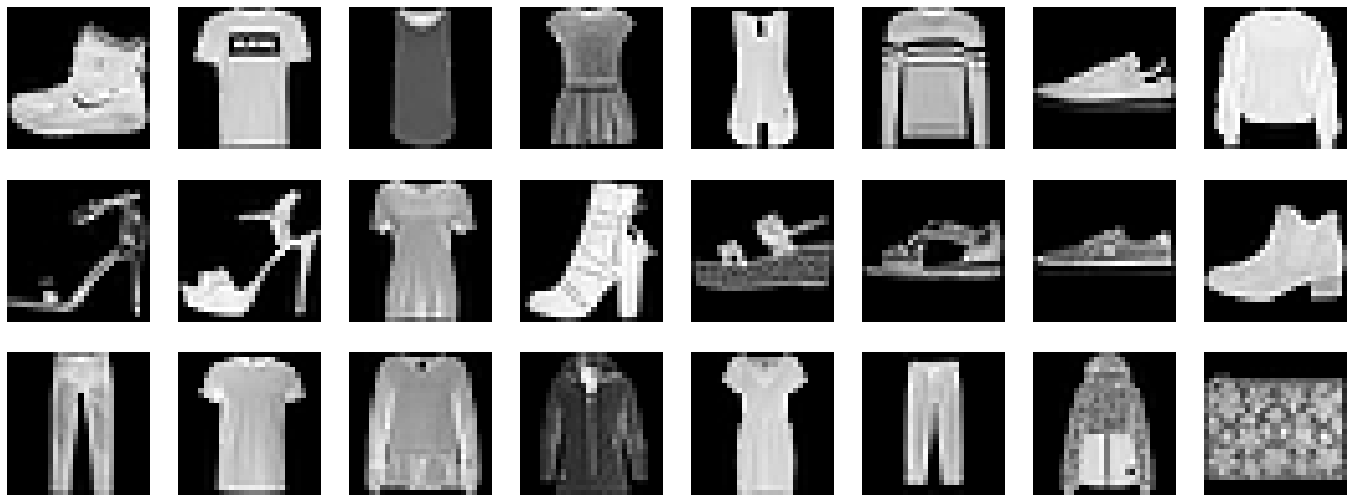

In [8]:
images = torch.cat(list(zip(*dataset))[0][:24]).unsqueeze(1)
plot_images(images, per_row=8, image_size=3)

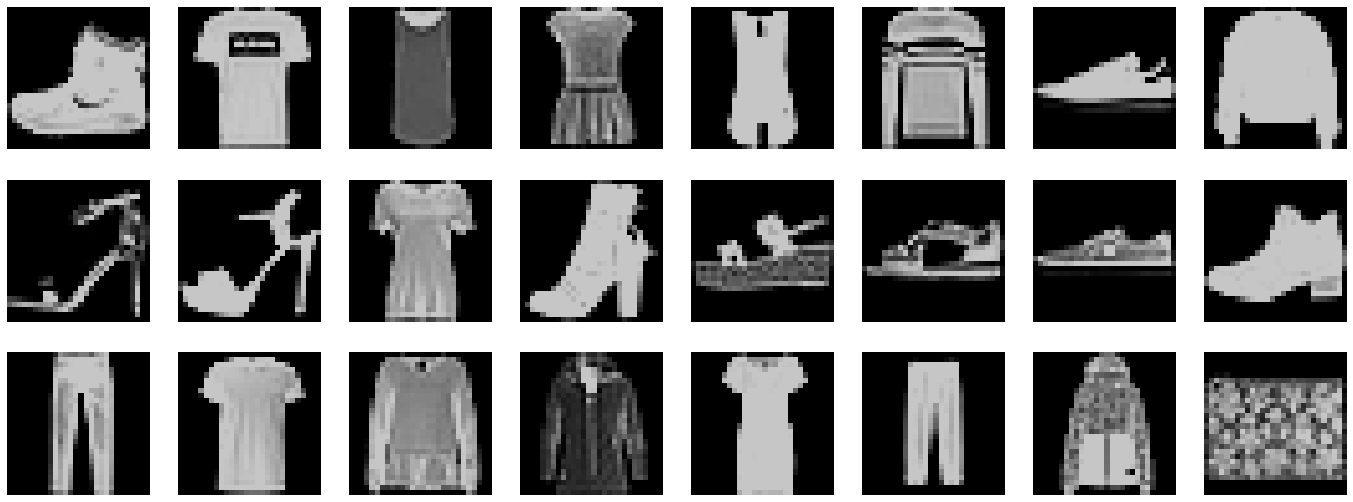

In [9]:
p = 1.5

t = tns.Compose([
    # nn.ZeroPad2d(4),
    # tns.RandomAffine(0, scale=(p, p)),
    # tns.RandomAffine(0, translate=(p, p)),
    # tns.RandomHorizontalFlip(p),
    tns.ColorJitter(contrast=(p, p))
])

t = tns.Compose([
    # tns.RandomAffine(0, scale=(1 - 1 * scale_unit, 1 + 1 * scale_unit)),
    tns.ColorJitter(brightness=(0.2, 2), contrast=(0.2, 2)),
])


new_images = t(images.to(device)).to(cpu)
plot_images(list(new_images), per_row=8, image_size=3)

In [10]:
!rm models/*

rm: cannot remove 'models/*': No such file or directory


In [11]:
!ls models

In [12]:
# scale_unit = 2 / 28
# translation_unit = 1 / 28

# transform = tns.Compose([
#     # tns.RandomAffine(0, scale=(1 - 1 * scale_unit, 1 + 1 * scale_unit)),
#     tns.ColorJitter(brightness=(0.4, 1.5), contrast=(0.4, 1.5)),
# ])

# class ResNetBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super().__init__()
#         self.stride = stride
        
#         self.block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#             nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
#             nn.BatchNorm2d(out_channels),
#         )
#         self.relu = nn.ReLU()
        
#         self.downsample = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
#             nn.BatchNorm2d(out_channels)
#         )
    
#     def forward(self, x):
#         identity = x if self.stride == 1 else self.downsample(x)
#         return self.relu(self.block(x) + identity)
    
# class ResNetLayer(nn.Module):
#     def __init__(self, blocks, in_channels, expand=True):
#         super().__init__()
        
#         stride = 2 if expand else 1
#         out_channels = stride * in_channels
#         layers = [ResNetBlock(in_channels, out_channels, stride)]
        
#         for _ in range(1, blocks):
#             layers.append(ResNetBlock(out_channels, out_channels))
            
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)

# class MyNet(nn.Module):
#     def __init__(self, blocks=2, first_channels=16, dropout=0.2):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(image_channels, first_channels, 3, padding='same', bias=False),
#             nn.BatchNorm2d(first_channels),
#             nn.ReLU(),
            
#             ResNetLayer(blocks, 2 ** 0 * first_channels, expand=False),
#             ResNetLayer(blocks, 2 ** 0 * first_channels),
#             ResNetLayer(blocks, 2 ** 1 * first_channels),
#             ResNetLayer(blocks, 2 ** 2 * first_channels),
            
#             nn.AdaptiveAvgPool2d((1, 1)),
#             nn.Flatten(1),
            
#             nn.Dropout(dropout),
#             nn.Linear(2 ** 3 * first_channels, n_classes),
#             nn.BatchNorm1d(n_classes),
#             nn.LogSoftmax(dim=1)
#         )
        
#     def forward(self, x):
#         return self.model(x)
    
# deeprn2 = MyNet()
    
# train(deeprn2,
#       train_dataset,
#       val_dataset,
#       transform=transform,
#       epochs=30,
#       lr=1e-3,
#       max_lr=1e-2,
#       weight_decay=1,
#       save=True,
#       saving_prefix='deeprn2',
#       verbose=True
#      )

In [13]:
# scale_unit = 2 / 28
# translation_unit = 1 / 28

# transform = tns.Compose([
#     tns.RandomAffine(0, scale=(1 - 1 * scale_unit, 1 + 1 * scale_unit)),
#     tns.ColorJitter(brightness=(0.3, 1.8), contrast=(0.3, 1.8)),
#     RandomGaussianNoise(0.05),
# ])

# class ResNetBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super().__init__()
#         self.stride = stride
        
#         self.block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#             nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
#             nn.BatchNorm2d(out_channels),
#         )
#         self.relu = nn.ReLU()
        
#         self.downsample = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
#             nn.BatchNorm2d(out_channels)
#         )
    
#     def forward(self, x):
#         identity = x if self.stride == 1 else self.downsample(x)
#         return self.relu(self.block(x) + identity)
    
# class ResNetLayer(nn.Module):
#     def __init__(self, blocks, in_channels, expand=True):
#         super().__init__()
        
#         stride = 2 if expand else 1
#         out_channels = stride * in_channels
#         layers = [ResNetBlock(in_channels, out_channels, stride)]
        
#         for _ in range(1, blocks):
#             layers.append(ResNetBlock(out_channels, out_channels))
            
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)

# class MyNet(nn.Module):
#     def __init__(self, blocks=10, first_channels=16, dropout=0.2):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(image_channels, first_channels, 3, padding='same', bias=False),
#             nn.BatchNorm2d(first_channels),
#             nn.ReLU(),
            
#             ResNetLayer(blocks, 2 ** 0 * first_channels, expand=False),
#             ResNetLayer(blocks, 2 ** 0 * first_channels),
#             ResNetLayer(blocks, 2 ** 1 * first_channels),
#             ResNetLayer(blocks, 2 ** 2 * first_channels),
            
#             nn.AdaptiveAvgPool2d((1, 1)),
#             nn.Flatten(1),
            
#             nn.Dropout(dropout),
#             nn.Linear(2 ** 3 * first_channels, n_classes),
#             nn.BatchNorm1d(n_classes),
#             nn.LogSoftmax(dim=1)
#         )
        
#     def forward(self, x):
#         return self.model(x)
    
# deeprn1 = MyNet()
    
# train(deeprn1,
#       train_dataset,
#       val_dataset,
#       transform=transform,
#       epochs=30,
#       lr=1e-3,
#       max_lr=1e-2,
#       weight_decay=0.1,
#       save=True,
#       saving_prefix='deeprn1',
#       verbose=True
#      )

In [14]:
scale_unit = 2 / 28
translation_unit = 1 / 28

transform = tns.Compose([
    tns.RandomAffine(0, scale=(1 - 1 * scale_unit, 1 + 1 * scale_unit)),
    tns.ColorJitter(brightness=(0.3, 1.8), contrast=(0.3, 1.8)),
    RandomGaussianNoise(0.1),
])

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.stride = stride
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        identity = x if self.stride == 1 else self.downsample(x)
        return self.relu(self.block(x) + identity)
    
class ResNetLayer(nn.Module):
    def __init__(self, blocks, in_channels, expand=True):
        super().__init__()
        
        stride = 2 if expand else 1
        out_channels = stride * in_channels
        layers = [ResNetBlock(in_channels, out_channels, stride)]
        
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
            
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class MyNet(nn.Module):
    def __init__(self, blocks=16, first_channels=16, dropout=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(image_channels, first_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(first_channels),
            nn.ReLU(),
            
            ResNetLayer(blocks, 2 ** 0 * first_channels, expand=False),
            ResNetLayer(blocks, 2 ** 0 * first_channels),
            ResNetLayer(blocks, 2 ** 1 * first_channels),
            ResNetLayer(blocks, 2 ** 2 * first_channels),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(1),
            
            nn.Dropout(dropout),
            nn.Linear(2 ** 3 * first_channels, n_classes),
            nn.BatchNorm1d(n_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)
    
deeprn2 = MyNet()
    
train(deeprn2,
      train_dataset,
      val_dataset,
      transform=transform,
      epochs=80,
      lr=1e-4,
      max_lr=1e-2,
      weight_decay=0.01,
      save=True,
      saving_prefix='deeprn2',
      verbose=True
     )

Training model with 6532046 parameters...
 1 - error: 0.653/0.648 - loss: 0.996/0.978 - elapsed time:  43s
 2 - error: 0.450/0.452 - loss: 0.861/0.893 - elapsed time:  83s
 3 - error: 0.326/0.337 - loss: 0.689/0.744 - elapsed time: 124s
 4 - error: 0.251/0.254 - loss: 0.601/0.586 - elapsed time: 165s
 5 - error: 0.218/0.221 - loss: 0.589/0.604 - elapsed time: 206s
 6 - error: 0.217/0.225 - loss: 0.681/0.728 - elapsed time: 247s
 7 - error: 0.187/0.182 - loss: 0.481/0.440 - elapsed time: 288s
 8 - error: 0.208/0.203 - loss: 0.761/0.755 - elapsed time: 329s
 9 - error: 0.199/0.195 - loss: 0.529/0.512 - elapsed time: 369s
10 - error: 0.177/0.187 - loss: 0.447/0.528 - elapsed time: 410s
11 - error: 0.177/0.194 - loss: 0.570/0.671 - elapsed time: 451s
12 - error: 0.151/0.159 - loss: 0.355/0.372 - elapsed time: 492s
13 - error: 0.152/0.162 - loss: 0.435/0.480 - elapsed time: 533s
14 - error: 0.143/0.149 - loss: 0.372/0.382 - elapsed time: 573s
15 - error: 0.143/0.148 - loss: 0.409/0.429 - el

In [ ]:
scale_unit = 2 / 28
translation_unit = 1 / 28

transform = tns.Compose([
    tns.RandomAffine(0, scale=(1 - 1 * scale_unit, 1 + 1 * scale_unit)),
    tns.ColorJitter(brightness=(0.3, 1.8), contrast=(0.3, 1.8)),
    RandomGaussianNoise(0.1),
])

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.stride = stride
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        identity = x if self.stride == 1 else self.downsample(x)
        return self.relu(self.block(x) + identity)
    
class ResNetLayer(nn.Module):
    def __init__(self, blocks, in_channels, expand=True):
        super().__init__()
        
        stride = 2 if expand else 1
        out_channels = stride * in_channels
        layers = [ResNetBlock(in_channels, out_channels, stride)]
        
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
            
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class MyNet(nn.Module):
    def __init__(self, blocks=16, first_channels=16, dropout=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(image_channels, first_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(first_channels),
            nn.ReLU(),
            
            ResNetLayer(blocks, 2 ** 0 * first_channels, expand=False),
            ResNetLayer(blocks, 2 ** 0 * first_channels),
            ResNetLayer(blocks, 2 ** 1 * first_channels),
            ResNetLayer(blocks, 2 ** 2 * first_channels),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(1),
            
            nn.Dropout(dropout),
            nn.Linear(2 ** 3 * first_channels, n_classes),
            nn.BatchNorm1d(n_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)
    
deeprn3 = MyNet()
    
train(deeprn3,
      train_dataset,
      val_dataset,
      transform=transform,
      epochs=80,
      lr=1e-3,
      max_lr=1e-2,
      weight_decay=0.01,
      save=True,
      saving_prefix='deeprn3',
      verbose=True
     )

Training model with 6532046 parameters...
 1 - error: 0.715/0.726 - loss: 1.440/1.496 - elapsed time:  40s
 2 - error: 0.471/0.488 - loss: 0.752/0.828 - elapsed time:  80s
 3 - error: 0.344/0.341 - loss: 0.717/0.644 - elapsed time: 121s
 4 - error: 0.277/0.262 - loss: 0.696/0.608 - elapsed time: 162s
 5 - error: 0.230/0.209 - loss: 0.564/0.474 - elapsed time: 203s
 6 - error: 0.220/0.198 - loss: 0.714/0.634 - elapsed time: 244s
 7 - error: 0.200/0.214 - loss: 0.543/0.698 - elapsed time: 285s
 8 - error: 0.180/0.188 - loss: 0.492/0.490 - elapsed time: 326s
 9 - error: 0.159/0.167 - loss: 0.425/0.457 - elapsed time: 366s
10 - error: 0.152/0.146 - loss: 0.429/0.378 - elapsed time: 407s
11 - error: 0.139/0.133 - loss: 0.383/0.351 - elapsed time: 448s
12 - error: 0.156/0.180 - loss: 0.512/0.704 - elapsed time: 489s
13 - error: 0.143/0.157 - loss: 0.377/0.390 - elapsed time: 530s
14 - error: 0.133/0.156 - loss: 0.370/0.466 - elapsed time: 570s
15 - error: 0.147/0.163 - loss: 0.532/0.569 - el

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# model = resnet3
model = load_model(MyNet(), 'assignment/model.pt').to(device)
dataset_to_analyze = dataset

RuntimeError: Error(s) in loading state_dict for MyNet:
	Missing key(s) in state_dict: "model.3.model.10.block.0.weight", "model.3.model.10.block.1.weight", "model.3.model.10.block.1.bias", "model.3.model.10.block.1.running_mean", "model.3.model.10.block.1.running_var", "model.3.model.10.block.3.weight", "model.3.model.10.block.4.weight", "model.3.model.10.block.4.bias", "model.3.model.10.block.4.running_mean", "model.3.model.10.block.4.running_var", "model.3.model.10.downsample.0.weight", "model.3.model.10.downsample.1.weight", "model.3.model.10.downsample.1.bias", "model.3.model.10.downsample.1.running_mean", "model.3.model.10.downsample.1.running_var", "model.3.model.11.block.0.weight", "model.3.model.11.block.1.weight", "model.3.model.11.block.1.bias", "model.3.model.11.block.1.running_mean", "model.3.model.11.block.1.running_var", "model.3.model.11.block.3.weight", "model.3.model.11.block.4.weight", "model.3.model.11.block.4.bias", "model.3.model.11.block.4.running_mean", "model.3.model.11.block.4.running_var", "model.3.model.11.downsample.0.weight", "model.3.model.11.downsample.1.weight", "model.3.model.11.downsample.1.bias", "model.3.model.11.downsample.1.running_mean", "model.3.model.11.downsample.1.running_var", "model.3.model.12.block.0.weight", "model.3.model.12.block.1.weight", "model.3.model.12.block.1.bias", "model.3.model.12.block.1.running_mean", "model.3.model.12.block.1.running_var", "model.3.model.12.block.3.weight", "model.3.model.12.block.4.weight", "model.3.model.12.block.4.bias", "model.3.model.12.block.4.running_mean", "model.3.model.12.block.4.running_var", "model.3.model.12.downsample.0.weight", "model.3.model.12.downsample.1.weight", "model.3.model.12.downsample.1.bias", "model.3.model.12.downsample.1.running_mean", "model.3.model.12.downsample.1.running_var", "model.3.model.13.block.0.weight", "model.3.model.13.block.1.weight", "model.3.model.13.block.1.bias", "model.3.model.13.block.1.running_mean", "model.3.model.13.block.1.running_var", "model.3.model.13.block.3.weight", "model.3.model.13.block.4.weight", "model.3.model.13.block.4.bias", "model.3.model.13.block.4.running_mean", "model.3.model.13.block.4.running_var", "model.3.model.13.downsample.0.weight", "model.3.model.13.downsample.1.weight", "model.3.model.13.downsample.1.bias", "model.3.model.13.downsample.1.running_mean", "model.3.model.13.downsample.1.running_var", "model.3.model.14.block.0.weight", "model.3.model.14.block.1.weight", "model.3.model.14.block.1.bias", "model.3.model.14.block.1.running_mean", "model.3.model.14.block.1.running_var", "model.3.model.14.block.3.weight", "model.3.model.14.block.4.weight", "model.3.model.14.block.4.bias", "model.3.model.14.block.4.running_mean", "model.3.model.14.block.4.running_var", "model.3.model.14.downsample.0.weight", "model.3.model.14.downsample.1.weight", "model.3.model.14.downsample.1.bias", "model.3.model.14.downsample.1.running_mean", "model.3.model.14.downsample.1.running_var", "model.3.model.15.block.0.weight", "model.3.model.15.block.1.weight", "model.3.model.15.block.1.bias", "model.3.model.15.block.1.running_mean", "model.3.model.15.block.1.running_var", "model.3.model.15.block.3.weight", "model.3.model.15.block.4.weight", "model.3.model.15.block.4.bias", "model.3.model.15.block.4.running_mean", "model.3.model.15.block.4.running_var", "model.3.model.15.downsample.0.weight", "model.3.model.15.downsample.1.weight", "model.3.model.15.downsample.1.bias", "model.3.model.15.downsample.1.running_mean", "model.3.model.15.downsample.1.running_var", "model.4.model.10.block.0.weight", "model.4.model.10.block.1.weight", "model.4.model.10.block.1.bias", "model.4.model.10.block.1.running_mean", "model.4.model.10.block.1.running_var", "model.4.model.10.block.3.weight", "model.4.model.10.block.4.weight", "model.4.model.10.block.4.bias", "model.4.model.10.block.4.running_mean", "model.4.model.10.block.4.running_var", "model.4.model.10.downsample.0.weight", "model.4.model.10.downsample.1.weight", "model.4.model.10.downsample.1.bias", "model.4.model.10.downsample.1.running_mean", "model.4.model.10.downsample.1.running_var", "model.4.model.11.block.0.weight", "model.4.model.11.block.1.weight", "model.4.model.11.block.1.bias", "model.4.model.11.block.1.running_mean", "model.4.model.11.block.1.running_var", "model.4.model.11.block.3.weight", "model.4.model.11.block.4.weight", "model.4.model.11.block.4.bias", "model.4.model.11.block.4.running_mean", "model.4.model.11.block.4.running_var", "model.4.model.11.downsample.0.weight", "model.4.model.11.downsample.1.weight", "model.4.model.11.downsample.1.bias", "model.4.model.11.downsample.1.running_mean", "model.4.model.11.downsample.1.running_var", "model.4.model.12.block.0.weight", "model.4.model.12.block.1.weight", "model.4.model.12.block.1.bias", "model.4.model.12.block.1.running_mean", "model.4.model.12.block.1.running_var", "model.4.model.12.block.3.weight", "model.4.model.12.block.4.weight", "model.4.model.12.block.4.bias", "model.4.model.12.block.4.running_mean", "model.4.model.12.block.4.running_var", "model.4.model.12.downsample.0.weight", "model.4.model.12.downsample.1.weight", "model.4.model.12.downsample.1.bias", "model.4.model.12.downsample.1.running_mean", "model.4.model.12.downsample.1.running_var", "model.4.model.13.block.0.weight", "model.4.model.13.block.1.weight", "model.4.model.13.block.1.bias", "model.4.model.13.block.1.running_mean", "model.4.model.13.block.1.running_var", "model.4.model.13.block.3.weight", "model.4.model.13.block.4.weight", "model.4.model.13.block.4.bias", "model.4.model.13.block.4.running_mean", "model.4.model.13.block.4.running_var", "model.4.model.13.downsample.0.weight", "model.4.model.13.downsample.1.weight", "model.4.model.13.downsample.1.bias", "model.4.model.13.downsample.1.running_mean", "model.4.model.13.downsample.1.running_var", "model.4.model.14.block.0.weight", "model.4.model.14.block.1.weight", "model.4.model.14.block.1.bias", "model.4.model.14.block.1.running_mean", "model.4.model.14.block.1.running_var", "model.4.model.14.block.3.weight", "model.4.model.14.block.4.weight", "model.4.model.14.block.4.bias", "model.4.model.14.block.4.running_mean", "model.4.model.14.block.4.running_var", "model.4.model.14.downsample.0.weight", "model.4.model.14.downsample.1.weight", "model.4.model.14.downsample.1.bias", "model.4.model.14.downsample.1.running_mean", "model.4.model.14.downsample.1.running_var", "model.4.model.15.block.0.weight", "model.4.model.15.block.1.weight", "model.4.model.15.block.1.bias", "model.4.model.15.block.1.running_mean", "model.4.model.15.block.1.running_var", "model.4.model.15.block.3.weight", "model.4.model.15.block.4.weight", "model.4.model.15.block.4.bias", "model.4.model.15.block.4.running_mean", "model.4.model.15.block.4.running_var", "model.4.model.15.downsample.0.weight", "model.4.model.15.downsample.1.weight", "model.4.model.15.downsample.1.bias", "model.4.model.15.downsample.1.running_mean", "model.4.model.15.downsample.1.running_var", "model.5.model.10.block.0.weight", "model.5.model.10.block.1.weight", "model.5.model.10.block.1.bias", "model.5.model.10.block.1.running_mean", "model.5.model.10.block.1.running_var", "model.5.model.10.block.3.weight", "model.5.model.10.block.4.weight", "model.5.model.10.block.4.bias", "model.5.model.10.block.4.running_mean", "model.5.model.10.block.4.running_var", "model.5.model.10.downsample.0.weight", "model.5.model.10.downsample.1.weight", "model.5.model.10.downsample.1.bias", "model.5.model.10.downsample.1.running_mean", "model.5.model.10.downsample.1.running_var", "model.5.model.11.block.0.weight", "model.5.model.11.block.1.weight", "model.5.model.11.block.1.bias", "model.5.model.11.block.1.running_mean", "model.5.model.11.block.1.running_var", "model.5.model.11.block.3.weight", "model.5.model.11.block.4.weight", "model.5.model.11.block.4.bias", "model.5.model.11.block.4.running_mean", "model.5.model.11.block.4.running_var", "model.5.model.11.downsample.0.weight", "model.5.model.11.downsample.1.weight", "model.5.model.11.downsample.1.bias", "model.5.model.11.downsample.1.running_mean", "model.5.model.11.downsample.1.running_var", "model.5.model.12.block.0.weight", "model.5.model.12.block.1.weight", "model.5.model.12.block.1.bias", "model.5.model.12.block.1.running_mean", "model.5.model.12.block.1.running_var", "model.5.model.12.block.3.weight", "model.5.model.12.block.4.weight", "model.5.model.12.block.4.bias", "model.5.model.12.block.4.running_mean", "model.5.model.12.block.4.running_var", "model.5.model.12.downsample.0.weight", "model.5.model.12.downsample.1.weight", "model.5.model.12.downsample.1.bias", "model.5.model.12.downsample.1.running_mean", "model.5.model.12.downsample.1.running_var", "model.5.model.13.block.0.weight", "model.5.model.13.block.1.weight", "model.5.model.13.block.1.bias", "model.5.model.13.block.1.running_mean", "model.5.model.13.block.1.running_var", "model.5.model.13.block.3.weight", "model.5.model.13.block.4.weight", "model.5.model.13.block.4.bias", "model.5.model.13.block.4.running_mean", "model.5.model.13.block.4.running_var", "model.5.model.13.downsample.0.weight", "model.5.model.13.downsample.1.weight", "model.5.model.13.downsample.1.bias", "model.5.model.13.downsample.1.running_mean", "model.5.model.13.downsample.1.running_var", "model.5.model.14.block.0.weight", "model.5.model.14.block.1.weight", "model.5.model.14.block.1.bias", "model.5.model.14.block.1.running_mean", "model.5.model.14.block.1.running_var", "model.5.model.14.block.3.weight", "model.5.model.14.block.4.weight", "model.5.model.14.block.4.bias", "model.5.model.14.block.4.running_mean", "model.5.model.14.block.4.running_var", "model.5.model.14.downsample.0.weight", "model.5.model.14.downsample.1.weight", "model.5.model.14.downsample.1.bias", "model.5.model.14.downsample.1.running_mean", "model.5.model.14.downsample.1.running_var", "model.5.model.15.block.0.weight", "model.5.model.15.block.1.weight", "model.5.model.15.block.1.bias", "model.5.model.15.block.1.running_mean", "model.5.model.15.block.1.running_var", "model.5.model.15.block.3.weight", "model.5.model.15.block.4.weight", "model.5.model.15.block.4.bias", "model.5.model.15.block.4.running_mean", "model.5.model.15.block.4.running_var", "model.5.model.15.downsample.0.weight", "model.5.model.15.downsample.1.weight", "model.5.model.15.downsample.1.bias", "model.5.model.15.downsample.1.running_mean", "model.5.model.15.downsample.1.running_var", "model.6.model.10.block.0.weight", "model.6.model.10.block.1.weight", "model.6.model.10.block.1.bias", "model.6.model.10.block.1.running_mean", "model.6.model.10.block.1.running_var", "model.6.model.10.block.3.weight", "model.6.model.10.block.4.weight", "model.6.model.10.block.4.bias", "model.6.model.10.block.4.running_mean", "model.6.model.10.block.4.running_var", "model.6.model.10.downsample.0.weight", "model.6.model.10.downsample.1.weight", "model.6.model.10.downsample.1.bias", "model.6.model.10.downsample.1.running_mean", "model.6.model.10.downsample.1.running_var", "model.6.model.11.block.0.weight", "model.6.model.11.block.1.weight", "model.6.model.11.block.1.bias", "model.6.model.11.block.1.running_mean", "model.6.model.11.block.1.running_var", "model.6.model.11.block.3.weight", "model.6.model.11.block.4.weight", "model.6.model.11.block.4.bias", "model.6.model.11.block.4.running_mean", "model.6.model.11.block.4.running_var", "model.6.model.11.downsample.0.weight", "model.6.model.11.downsample.1.weight", "model.6.model.11.downsample.1.bias", "model.6.model.11.downsample.1.running_mean", "model.6.model.11.downsample.1.running_var", "model.6.model.12.block.0.weight", "model.6.model.12.block.1.weight", "model.6.model.12.block.1.bias", "model.6.model.12.block.1.running_mean", "model.6.model.12.block.1.running_var", "model.6.model.12.block.3.weight", "model.6.model.12.block.4.weight", "model.6.model.12.block.4.bias", "model.6.model.12.block.4.running_mean", "model.6.model.12.block.4.running_var", "model.6.model.12.downsample.0.weight", "model.6.model.12.downsample.1.weight", "model.6.model.12.downsample.1.bias", "model.6.model.12.downsample.1.running_mean", "model.6.model.12.downsample.1.running_var", "model.6.model.13.block.0.weight", "model.6.model.13.block.1.weight", "model.6.model.13.block.1.bias", "model.6.model.13.block.1.running_mean", "model.6.model.13.block.1.running_var", "model.6.model.13.block.3.weight", "model.6.model.13.block.4.weight", "model.6.model.13.block.4.bias", "model.6.model.13.block.4.running_mean", "model.6.model.13.block.4.running_var", "model.6.model.13.downsample.0.weight", "model.6.model.13.downsample.1.weight", "model.6.model.13.downsample.1.bias", "model.6.model.13.downsample.1.running_mean", "model.6.model.13.downsample.1.running_var", "model.6.model.14.block.0.weight", "model.6.model.14.block.1.weight", "model.6.model.14.block.1.bias", "model.6.model.14.block.1.running_mean", "model.6.model.14.block.1.running_var", "model.6.model.14.block.3.weight", "model.6.model.14.block.4.weight", "model.6.model.14.block.4.bias", "model.6.model.14.block.4.running_mean", "model.6.model.14.block.4.running_var", "model.6.model.14.downsample.0.weight", "model.6.model.14.downsample.1.weight", "model.6.model.14.downsample.1.bias", "model.6.model.14.downsample.1.running_mean", "model.6.model.14.downsample.1.running_var", "model.6.model.15.block.0.weight", "model.6.model.15.block.1.weight", "model.6.model.15.block.1.bias", "model.6.model.15.block.1.running_mean", "model.6.model.15.block.1.running_var", "model.6.model.15.block.3.weight", "model.6.model.15.block.4.weight", "model.6.model.15.block.4.bias", "model.6.model.15.block.4.running_mean", "model.6.model.15.block.4.running_var", "model.6.model.15.downsample.0.weight", "model.6.model.15.downsample.1.weight", "model.6.model.15.downsample.1.bias", "model.6.model.15.downsample.1.running_mean", "model.6.model.15.downsample.1.running_var". 

In [ ]:
plot_size = 3

conv_filters = list(model.parameters())[0].squeeze().to(cpu).detach()
n = len(conv_filters)

figure = plt.figure(figsize=(n * plot_size, plot_size))
plt.title('Learned convolution filters (the first convolutional layer)')
plt.axis("off")

for i, cf in enumerate(conv_filters):
    figure.add_subplot(1, n, i + 1)
    plt.axis("off")
    plt.imshow(cf, cmap='gray')

plt.show()

In [ ]:
plot_scale = 1.5
sns.set(font_scale=1)

def get_ground_truth_and_predictions(dataset, batch_size = 1024):
    n = len(dataset)
    y = torch.Tensor(n)
    pred = torch.Tensor(n)

    for b, (X, y_local) in enumerate(td.DataLoader(dataset, batch_size)):
        start = b * batch_size
        end = min(start + batch_size, n)
        pred[start:end] = classify(model(X.to(device)))
        y[start:end] = y_local
    
    return y, pred.to(cpu)

y, pred = get_ground_truth_and_predictions(dataset_to_analyze)
cm = confusion_matrix(pred, y)
error = np.sum(cm, 1) - np.diagonal(cm)
labels = list(label_map_dict.values())
df = pd.DataFrame(error, index=labels, columns=['Error']).T

plt.figure(figsize=(n_classes * plot_scale, 1.5 * plot_scale))
sns.heatmap(df, annot=True, fmt='d', cbar=False, square=True, yticklabels=False).set_title('Misclassified samples')

In [ ]:
plot_size = 10

cm_copy = np.copy(cm)
np.fill_diagonal(cm_copy, 0)
vmax = np.max(cm_copy)
df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(plot_size, plot_size))
sns.heatmap(df, vmax=vmax, annot=True, fmt='d', cbar=False, square=True).set(xlabel='Predicted label', ylabel='Ground truth')
plt.yticks(rotation=0)
plt.show()

In [ ]:
# def plot_misclassified(ground_truth, predicted_label, start_idx, n):
#     mask = torch.logical_and(y == label_map_reverse(ground_truth), pred == label_map_reverse(predicted_label))
#     indices = mask.nonzero()
#     subset = [dataset_to_analyze[i] for i in indices][start_idx:start_idx + n]
#     print(f'\'{ground_truth}\' classified as \'{pred_label}\'')
#     plot_dataset(subset)
    
# plot_misclassified('T-Shirt', 'Shirt', 5000, 48)
# plot_misclassified('Shirt', 'T-Shirt', 0, 48)